# Data Analytics Exercise
The data set examined comes from Keggle (https://www.kaggle.com/datasets/willianoliveiragibin/healthcare-insurance).
This dataset contains information on the relationship between personal attributes (age, gender, BMI, family size, smoking habits), geographic factors, and their impact on medical insurance charges. It can be used to study how these features influence insurance costs and develop predictive models for estimating healthcare expenses.

The goal of this analysis is to obtain an overview which attributes have an impact on medical insurance costs.

In [23]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

In [24]:
path = kagglehub.dataset_download("willianoliveiragibin/healthcare-insurance")

df = pd.read_csv(path + "/insurance.csv", encoding="utf8")

## 1. Data Overview and Cleaning

The dataset was inspected for missing values, inconsistencies, and duplicates. Overall, the data was found to be very clean. No missing values were present, and only a single duplicate observation was identified and removed. No further preprocessing steps were required at this stage.

In [25]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [26]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [27]:
df.duplicated().sum()

np.int64(1)

In [28]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [29]:
df['log_charges'] = np.log(df['charges'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          1337 non-null   int64  
 1   sex          1337 non-null   object 
 2   bmi          1337 non-null   float64
 3   children     1337 non-null   int64  
 4   smoker       1337 non-null   object 
 5   region       1337 non-null   object 
 6   charges      1337 non-null   float64
 7   log_charges  1337 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 94.0+ KB


## 2. Univariate Analysis

Univariate analysis was conducted to understand the distribution and basic characteristics of individual features.

- **Numerical features** were analyzed using histograms and boxplots to assess their distributions, spread, skewness, and the presence of outliers.
- **Categorical features** were analyzed using bar plots to visualize category frequencies and identify class imbalances.

This step provided an initial understanding of the data ranges and variability.

Due to the strong right-skewness of the `charges` distribution, a log-transformed version (`log(charges)`) was additionally analyzed. The same correlation and group analyses were repeated using the transformed target to:

- Reduce the influence of extreme values,
- Improve interpretability of linear relationships,
- Assess whether relationships are more consistent on a logarithmic scale.

In [30]:
def plot_distributions(
    df,
    columns,
    bins=None,
    kde=True,
    figsize=(8, 5),
    title=None
):
    """
    Plot the distribution of numerical columns with adaptive bins.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    columns : list of str
        Numerical columns to plot.
    bins : int or None, optional
        Number of histogram bins. If None, calculated automatically.
    kde : bool, optional
        Whether to show KDE curve.
    figsize : tuple, optional
        Figure size.
    title : str, optional
        Plot title.
    """
    for column in columns:
        plt.figure(figsize=figsize)

        # adaptive bin calculation if bins=None
        if bins is None:
            # Freedman-Diaconis rule
            q75, q25 = np.percentile(df[column], [75 ,25])
            iqr = q75 - q25
            bin_width = 2 * iqr * len(df[column]) ** (-1/3)
            if bin_width > 0:
                bins_calc = int(np.ceil((df[column].max() - df[column].min()) / bin_width))
            else:
                bins_calc = 10  # fallback
        else:
            bins_calc = bins

        sns.histplot(df[column], bins=bins_calc, kde=kde)

        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.title(title if title else f"Distribution of {column}")
        plt.tight_layout()
        plt.show()


def plot_boxplots(
    df,
    columns,
    figsize=(8, 5),
    title=None
):
    """
    Plot boxplots for numerical columns.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe
    columns : list of str
        Numerical columns to plot
    figsize : tuple, optional
        Figure size
    title : str, optional
        Plot title
    """
    for column in columns:
        plt.figure(figsize=figsize)
        sns.boxplot(x=df[column])
        
        plt.xlabel(column)
        plt.title(title if title else f"Boxplot of {column}")
        plt.tight_layout()
        plt.show()

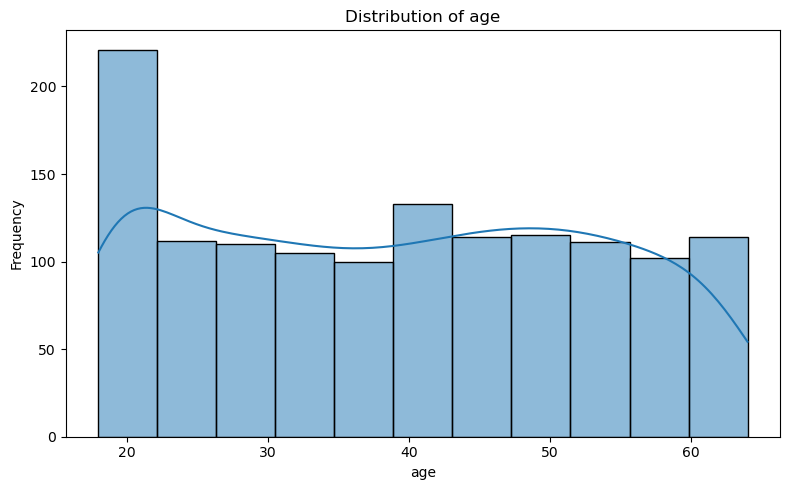

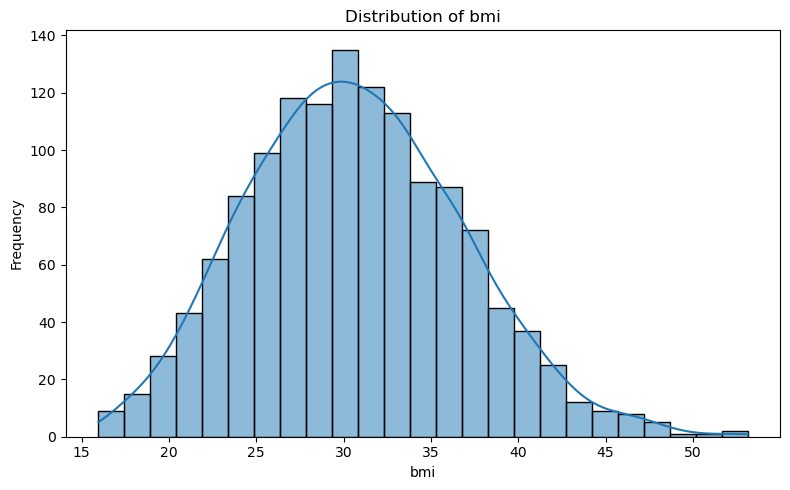

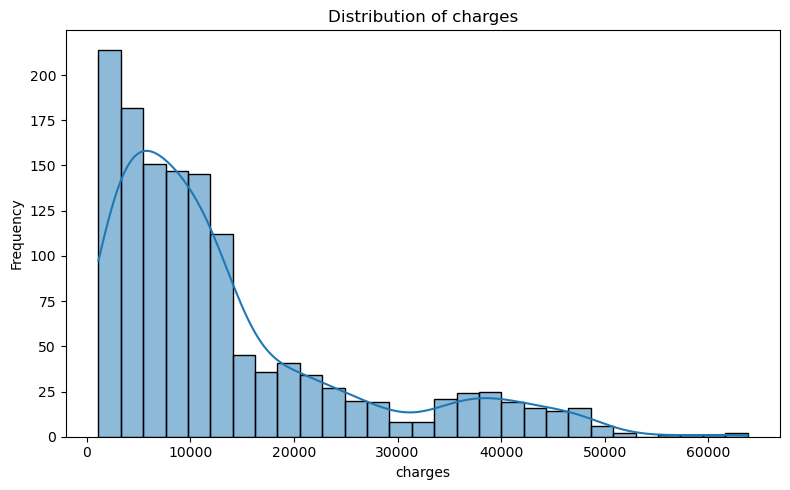

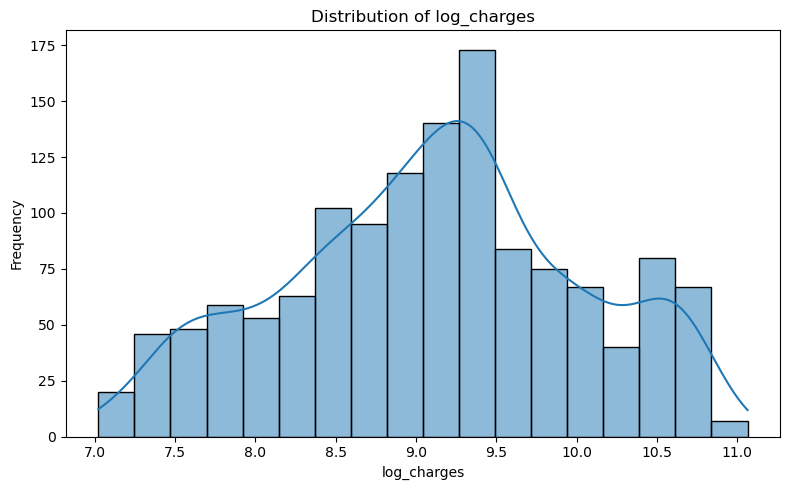

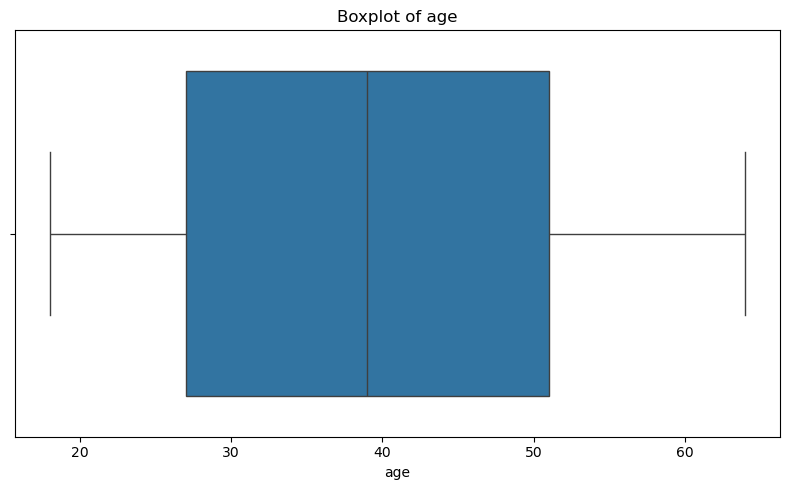

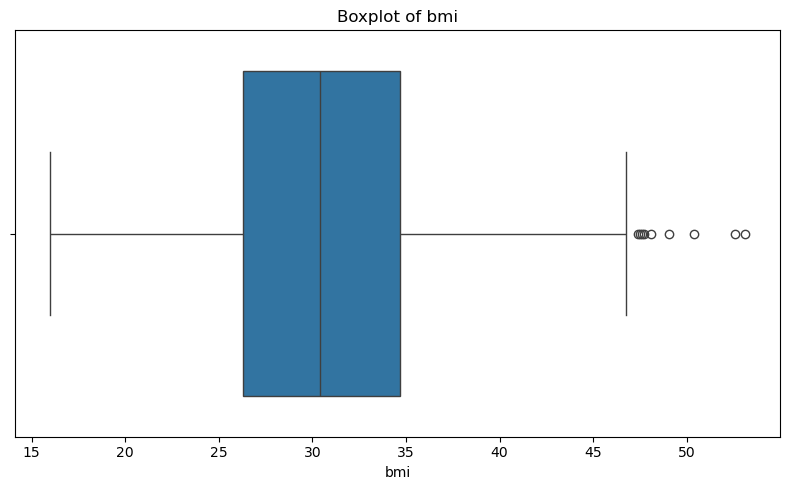

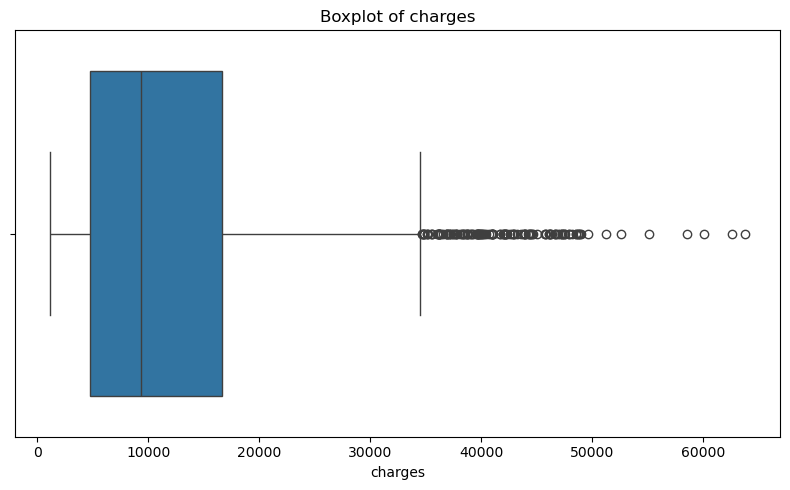

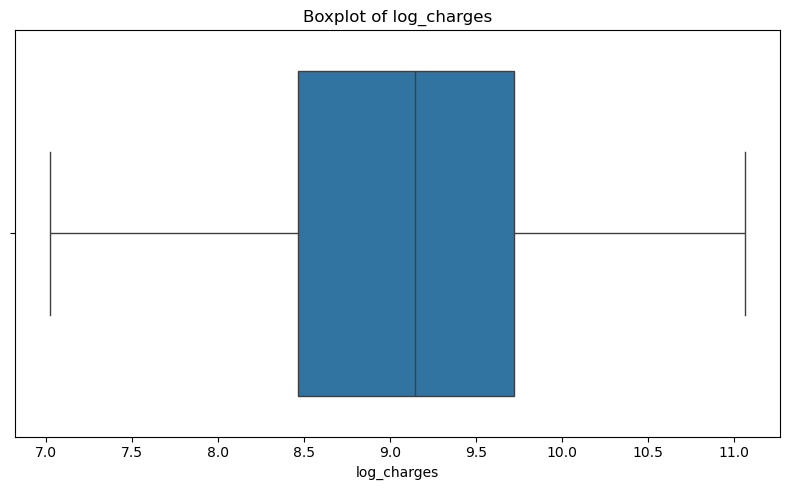

In [31]:
columns = ["age", "bmi", "charges", "log_charges"]
plot_distributions(df, columns)
plot_boxplots(df, columns)

In [32]:
def plot_categorical_distributions(
    df,
    columns,
    figsize=(7, 5),
    rotation=45,
    title=None
):
    """
    Plot the distribution of categorical columns.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    columns : list of str
        Categorical columns to plot.
    figsize : tuple, optional
        Figure size.
    title : str, optional
        Plot title.
    """
    for column in columns:
        plt.figure(figsize=figsize)
        ax = sns.countplot(x=column, data=df)
        
        ax.tick_params(axis="x", rotation=rotation)
        plt.xlabel(column)
        plt.ylabel("Count")
        plt.title(title if title else f"Distribution of {column}")
        plt.tight_layout()
        plt.show()

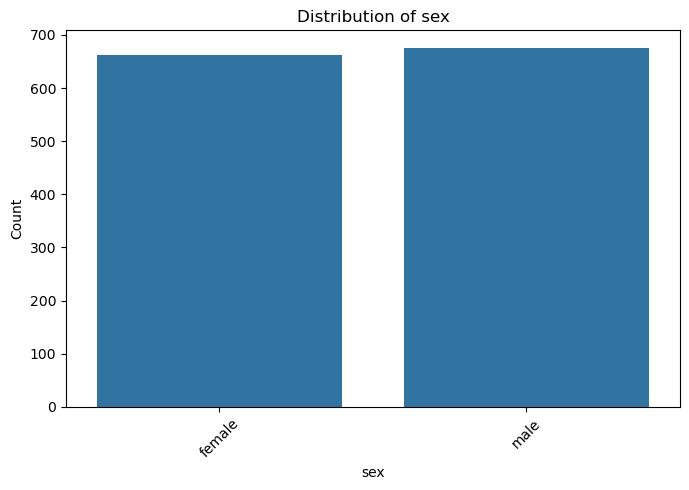

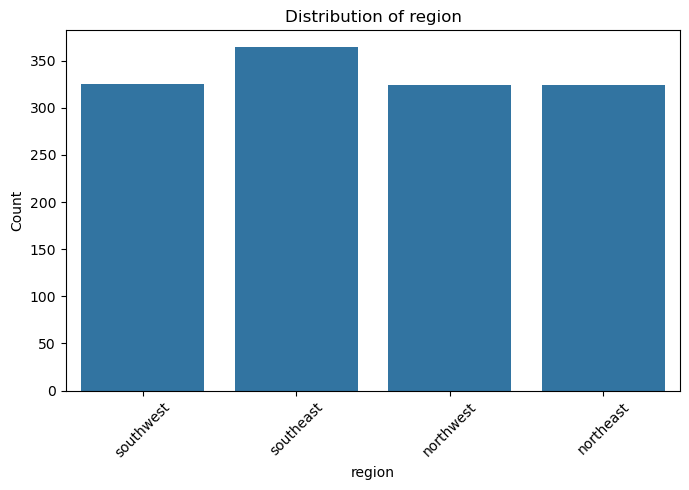

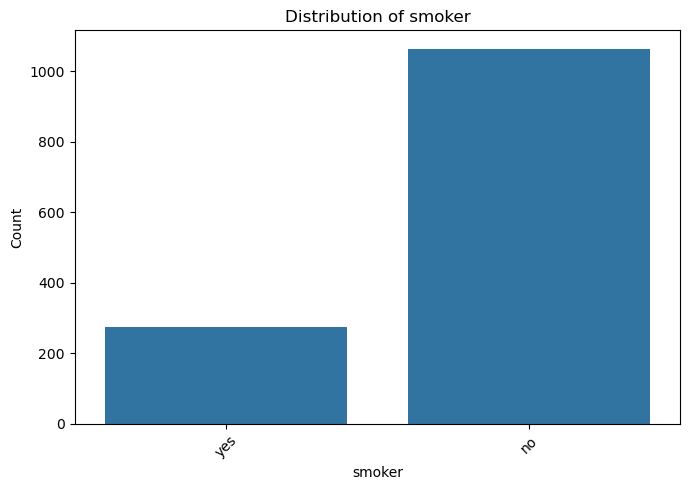

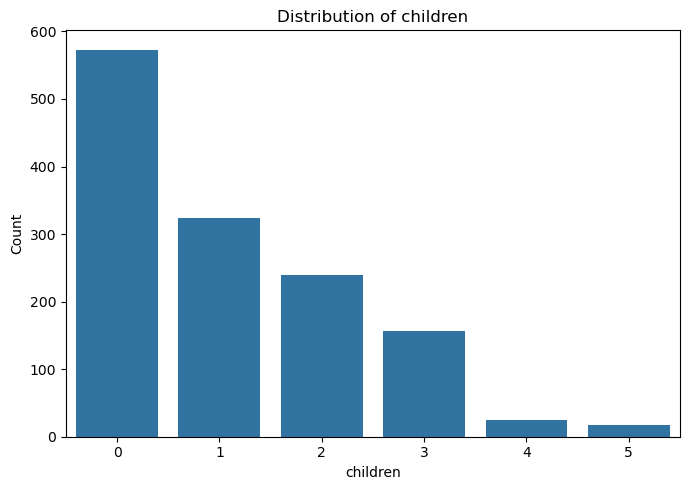

In [33]:
columns = ["sex", "region", "smoker"]
plot_categorical_distributions(df, columns)
plot_categorical_distributions(df, ["children"], rotation=0)

## 3. Bivariate Analysis with Target Variable

To investigate relationships between features and the target variable (`charges`), several bivariate analyses were performed:

- **Numerical features vs. charges** were examined using scatter plots to identify linear or monotonic trends.
- **Categorical features vs. charges** were analyzed using boxplots to compare distributions across groups.
- Combined visualizations using a **hue parameter** (e.g., smoker status) were used to assess interaction effects between numerical and categorical variables.

These plots revealed clear differences in charges across certain groups, particularly for smoking status.

In [34]:
def plot_numeric_vs_target(
    df,
    numeric_feature,
    target,
    figsize=(7, 5),
    title=None,
    hue=None,
    alpha=0.6
):
    """
    Scatter plot of a numerical feature vs a target variable.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    numeric_feature : str
        Numerical feature column (x-axis).
    target : str
        Target numeric variable column (y-axis).
    figsize : tuple, optional
        Figure size.
    title : str, optional
        Plot title. If None, generates automatically.
    hue : str, optional
        Categorical column for coloring the points.
    alpha : float, optional
        Point transparency.
    """
    plt.figure(figsize=figsize)
    sns.scatterplot(x=numeric_feature, y=target, data=df, hue=hue, alpha=alpha)
    
    plt.xlabel(numeric_feature)
    plt.ylabel(target)
    plt.title(title if title else f"{target} vs {numeric_feature}" + (f" by {hue}" if hue else ""))
    plt.tight_layout()
    plt.show()


def plot_numeric_by_category(
    df,
    numeric_col,
    category_col,
    plot_type="box",
    hue=None,
    figsize=(7,5),
    rotation = 30,
    title=None
):
    """
    Plot a numeric column by categorical groups.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe
    numeric_col : str
        Numerical column (e.g., charges)
    category_col : str
        Categorical column (e.g., smoker)
    plot_type : str
        "box" or "violin"
    hue : str, optional
        Optional second categorical variable for subgrouping
    figsize : tuple
        Figure size
    rotation : int
        Rotation of x-labels
    title : str, optional
        Plot title
    """
    plt.figure(figsize=figsize)
    
    if plot_type == "box":
        ax = sns.boxplot(x=category_col, y=numeric_col, hue=hue, data=df)
    elif plot_type == "violin":
        ax = sns.violinplot(x=category_col, y=numeric_col, hue=hue, data=df, inner="quartile")
    else:
        raise ValueError("plot_type must be 'box' or 'violin'")
    
    ax.tick_params(axis="x", rotation=rotation)
    plt.xlabel(category_col)
    plt.ylabel(numeric_col)
    plt.title(title if title else f"{numeric_col} by {category_col}" + (f" grouped by {hue}" if hue else ""))
    plt.tight_layout()
    plt.show()

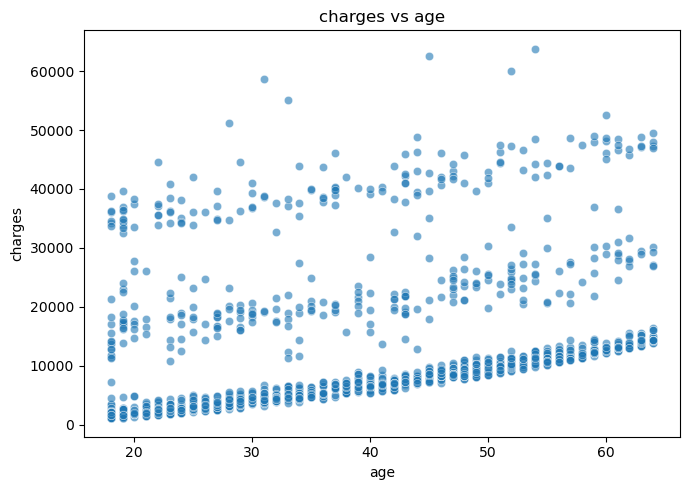

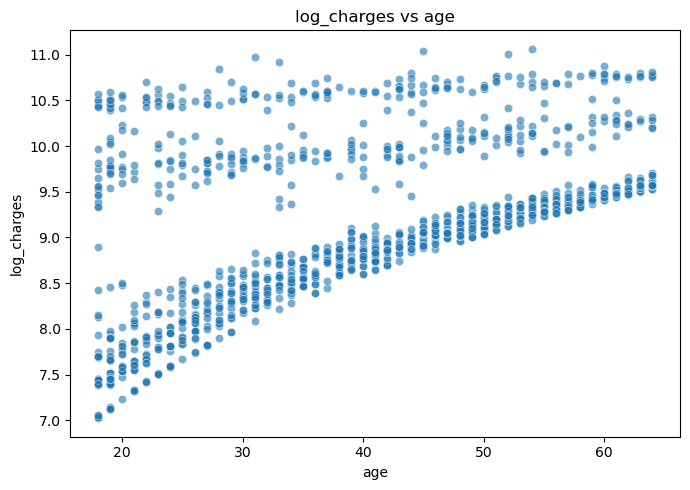

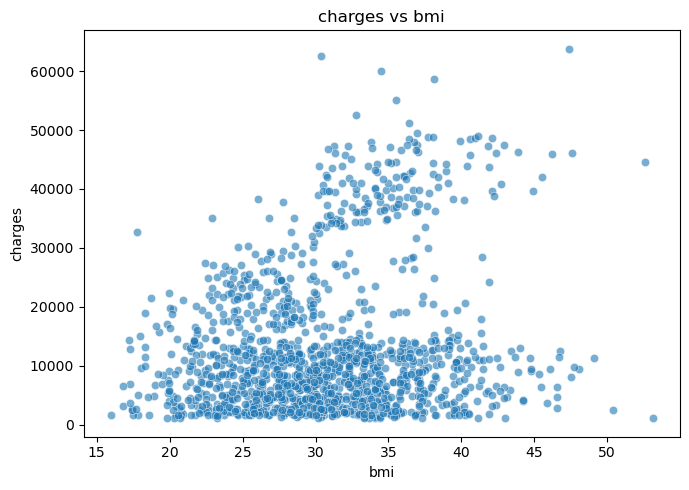

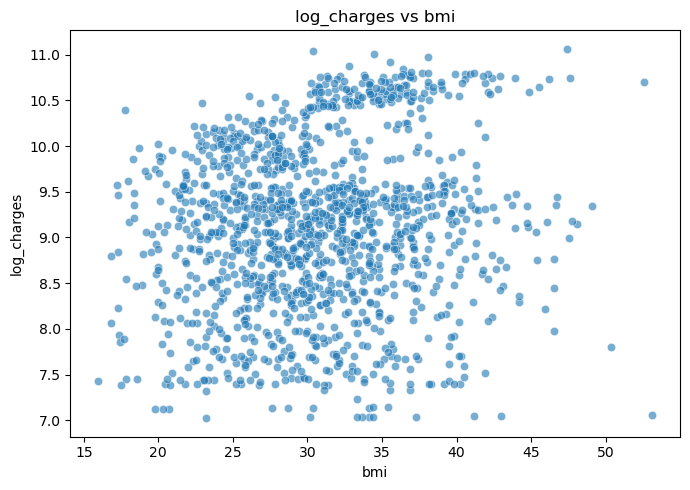

In [35]:
# plot_numeric_vs_target(df, numeric_feature="charges", target="log_charges")

plot_numeric_vs_target(df, numeric_feature="age", target="charges")
plot_numeric_vs_target(df, numeric_feature="age", target="log_charges")

plot_numeric_vs_target(df, numeric_feature="bmi", target="charges")
plot_numeric_vs_target(df, numeric_feature="bmi", target="log_charges")

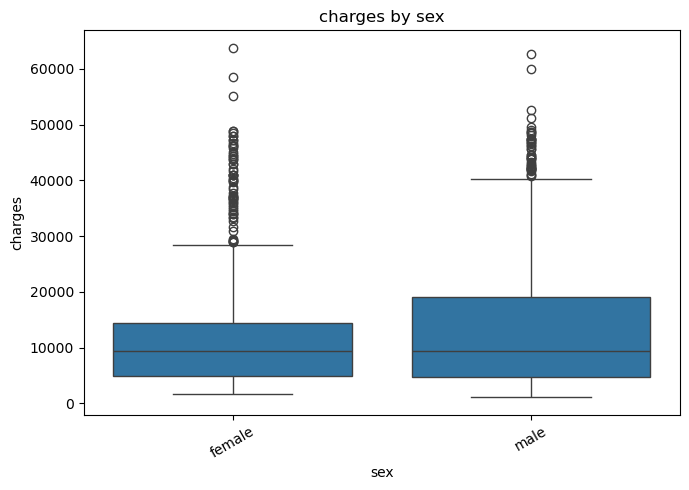

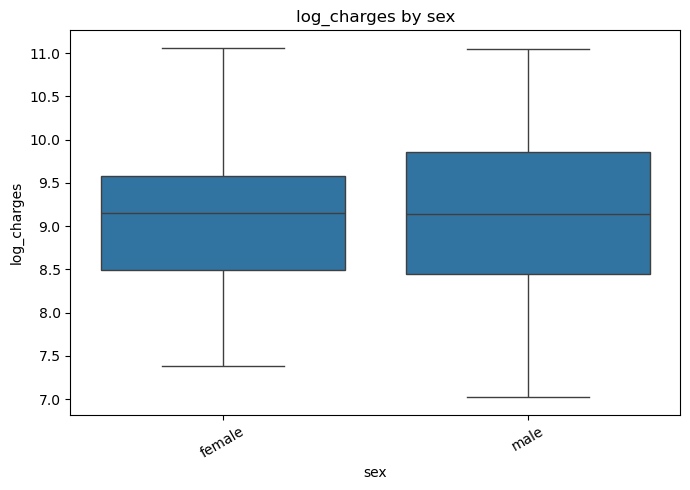

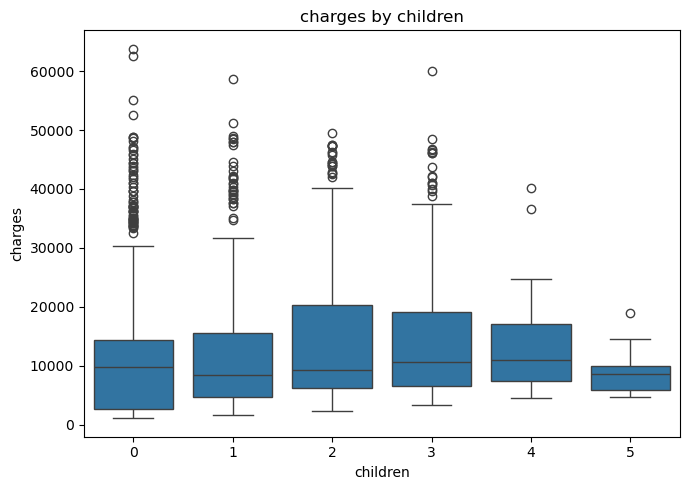

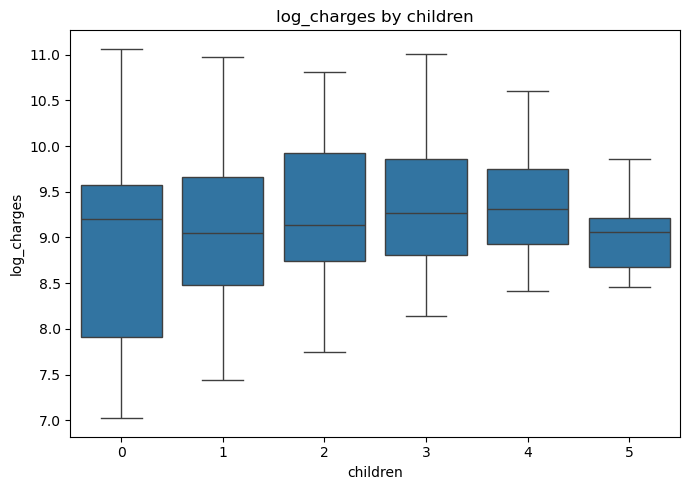

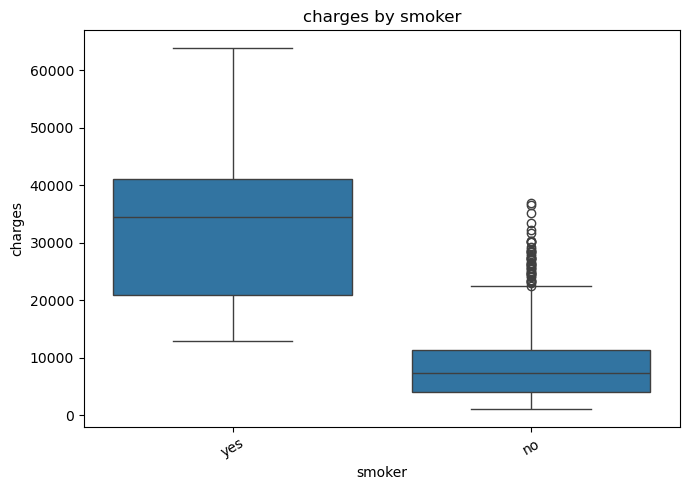

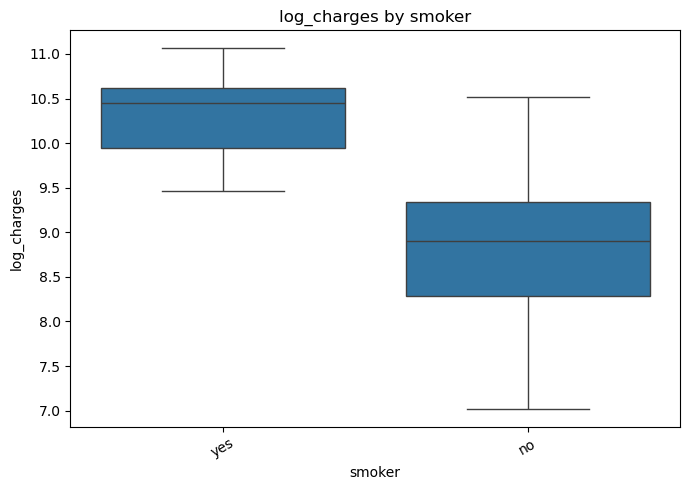

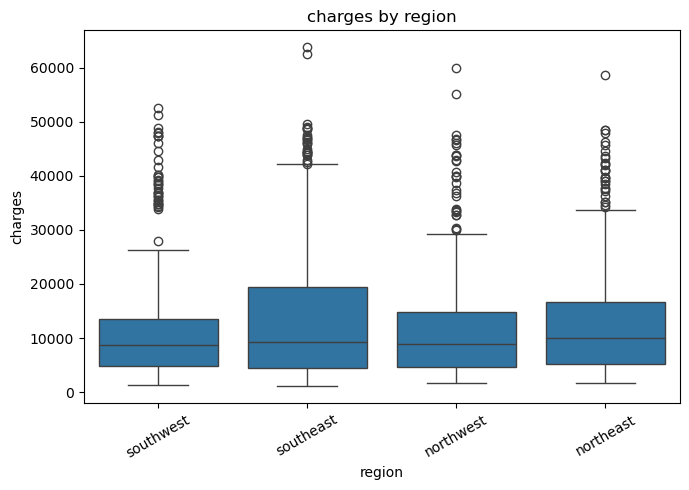

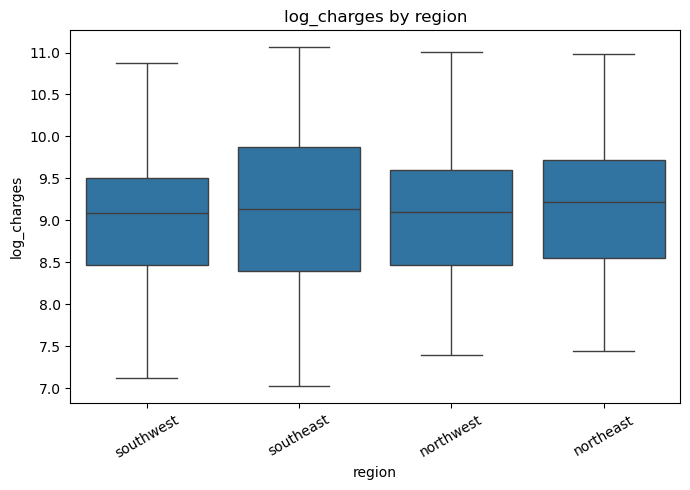

In [36]:
plot_numeric_by_category(df, numeric_col="charges", category_col="sex")
plot_numeric_by_category(df, numeric_col="log_charges", category_col="sex")

plot_numeric_by_category(df, numeric_col="charges", category_col="children", rotation=0)
plot_numeric_by_category(df, numeric_col="log_charges", category_col="children", rotation=0)

plot_numeric_by_category(df, numeric_col="charges", category_col="smoker")
plot_numeric_by_category(df, numeric_col="log_charges", category_col="smoker")

plot_numeric_by_category(df, numeric_col="charges", category_col="region")
plot_numeric_by_category(df, numeric_col="log_charges", category_col="region")

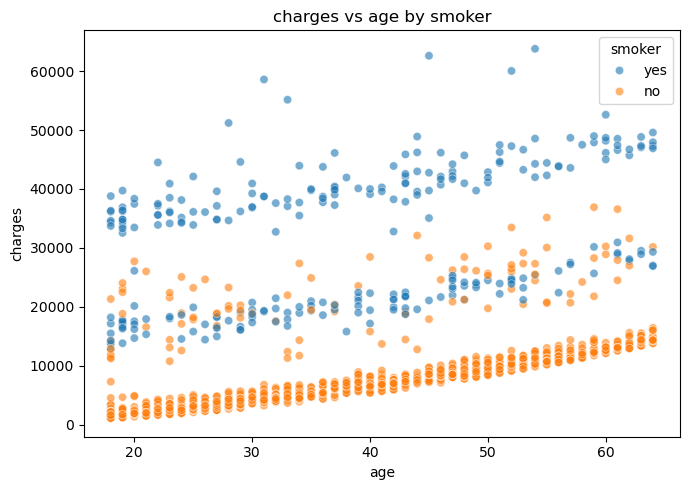

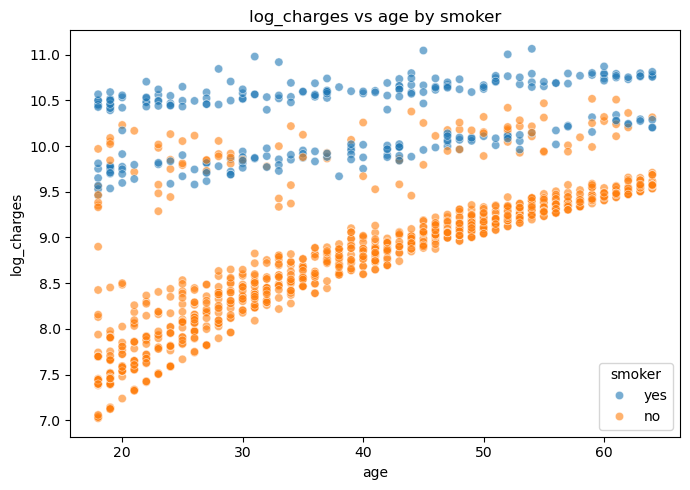

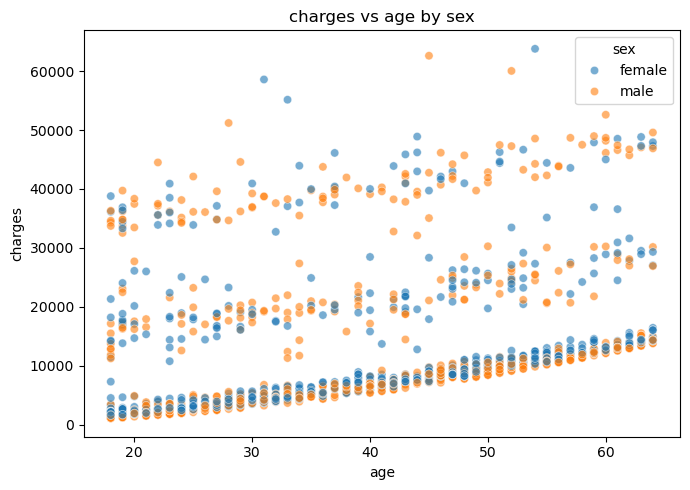

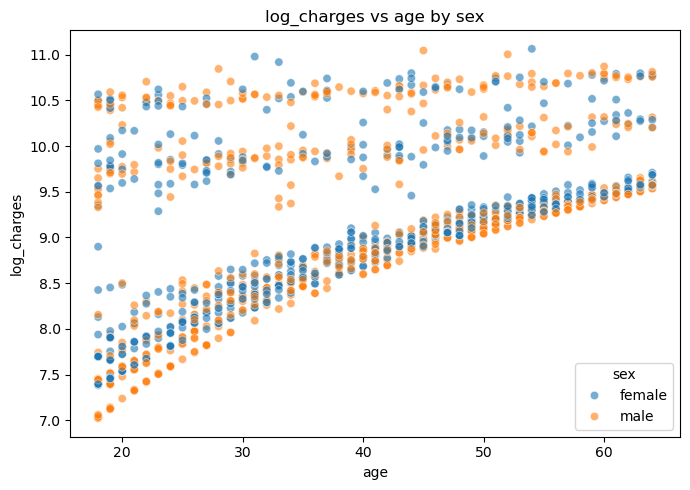

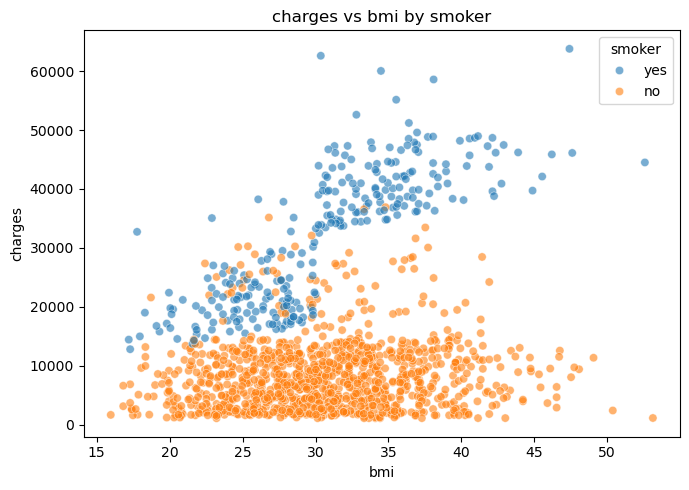

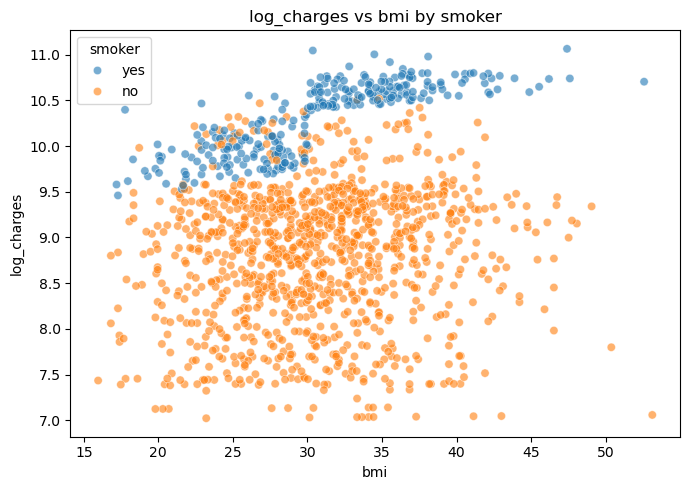

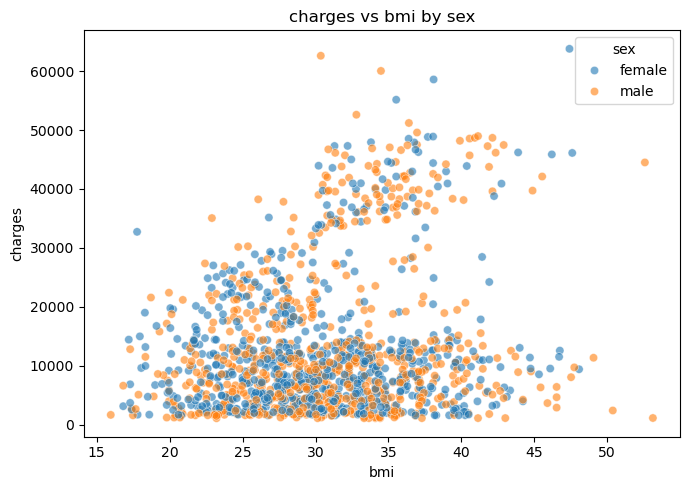

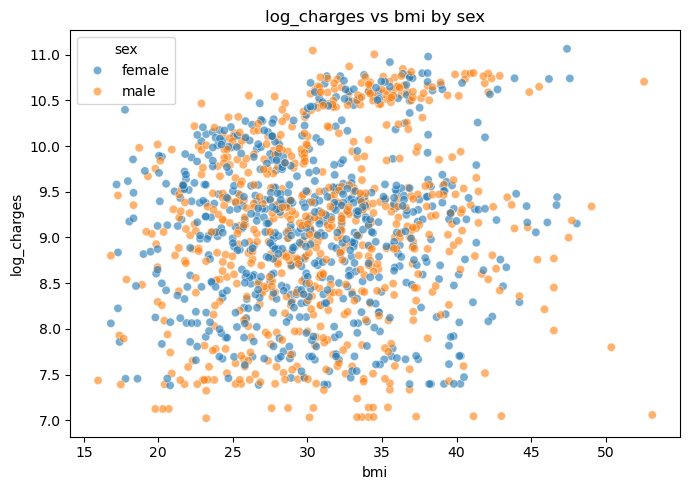

In [37]:
plot_numeric_vs_target(df, numeric_feature="age", target="charges", hue="smoker")
plot_numeric_vs_target(df, numeric_feature="age", target="log_charges", hue="smoker")

plot_numeric_vs_target(df, numeric_feature="age", target="charges", hue="sex")
plot_numeric_vs_target(df, numeric_feature="age", target="log_charges", hue="sex")

plot_numeric_vs_target(df, numeric_feature="bmi", target="charges", hue="smoker")
plot_numeric_vs_target(df, numeric_feature="bmi", target="log_charges", hue="smoker")

plot_numeric_vs_target(df, numeric_feature="bmi", target="charges", hue="sex")
plot_numeric_vs_target(df, numeric_feature="bmi", target="log_charges", hue="sex")

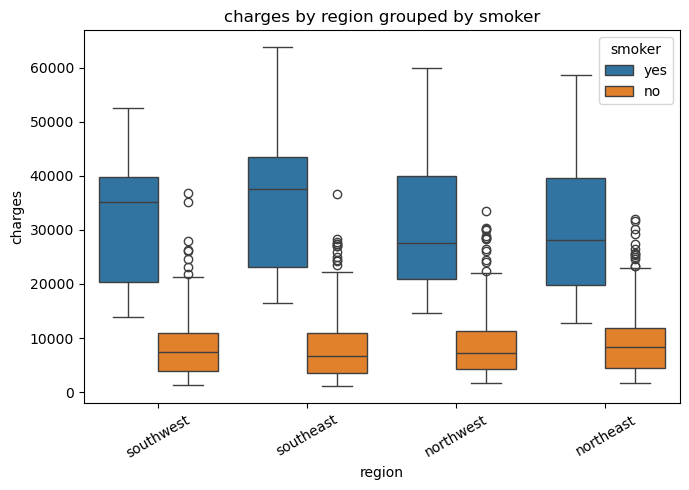

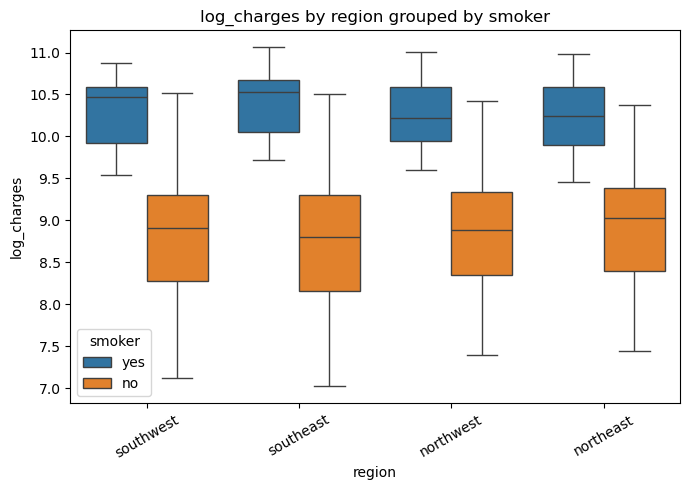

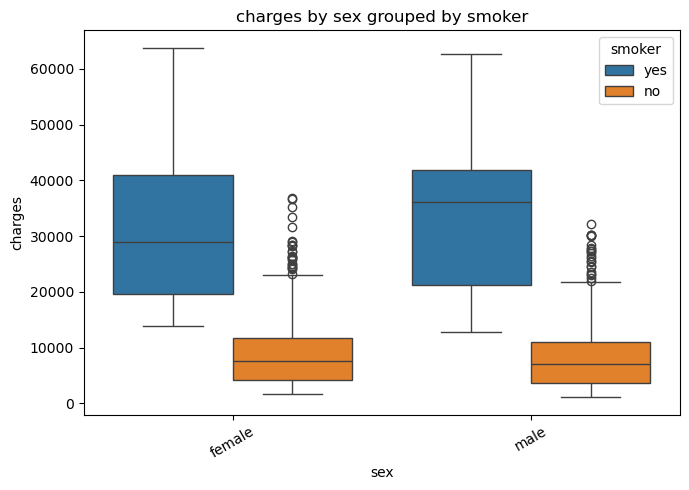

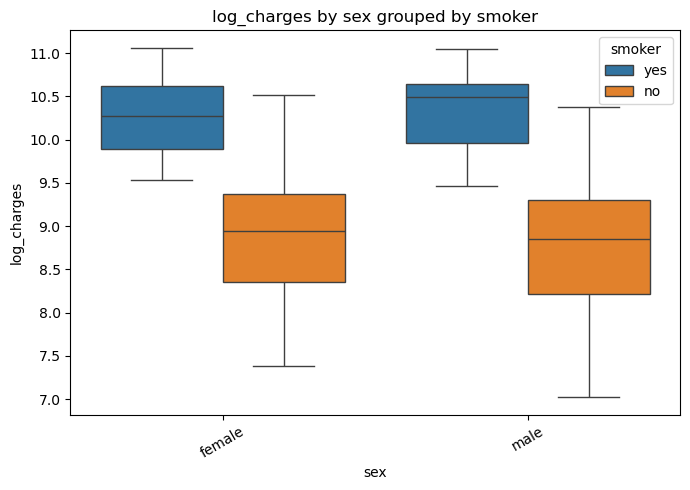

In [38]:
plot_numeric_by_category(df, numeric_col="charges", category_col="region", hue="smoker")
plot_numeric_by_category(df, numeric_col="log_charges", category_col="region", hue="smoker")

plot_numeric_by_category(df, numeric_col="charges", category_col="sex", hue="smoker")
plot_numeric_by_category(df, numeric_col="log_charges", category_col="sex", hue="smoker")

## Interpretation of Key Relationships

- ### Charges vs. Smoker
Smoking status shows the strongest effect on insurance charges. Smokers have significantly higher and more variable medical costs compared to non-smokers, indicating that smoking is a major risk factor driving insurance expenses.

- ### Charges vs. Age
Insurance charges increase with age, showing a clear positive trend. This suggests that healthcare costs tend to rise as individuals get older, likely due to increased health risks and medical needs.

- ### Charges vs. BMI
Higher BMI values are associated with higher insurance charges, but the relationship is less linear and characterized by strong outliers. This indicates that extreme BMI values can lead to disproportionately high medical costs.

- ### Charges vs. Region
The region has a relatively weak influence on insurance charges. While some differences between regions exist, they are small compared to the effects of smoking, age, or BMI, suggesting that regional factors play a minor role in cost variation.








## 4. Correlation Analysis

Correlation analysis was conducted to quantify the strength and direction of relationships:

- **Pearson correlation** was used to measure linear relationships between numerical variables and the target.
- **Spearman correlation** was used to assess monotonic relationships, especially in the presence of non-linear patterns.
- For binary categorical variables (e.g., smoker), **point-biserial correlation** was computed, including significance testing.

Correlation results were visualized and ranked to highlight the most influential features.

In [39]:
def compute_correlation_matrix(
    df,
    method="pearson",
    include_columns=None,
    exclude_columns=None
):
    """
    Compute a correlation matrix for numerical features.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    method : str, optional
        Correlation method ('pearson', 'spearman', 'kendall').
    include_columns : list of str, optional
        Columns to explicitly include.
    exclude_columns : list of str, optional
        Columns to exclude.

    Returns
    -------
    pandas.DataFrame
        Correlation matrix.
    """
    data = df.copy()

    if include_columns is not None:
        data = data[include_columns]

    numeric_df = data.select_dtypes(include="number")

    if exclude_columns is not None:
        numeric_df = numeric_df.drop(columns=exclude_columns, errors="ignore")

    return numeric_df.corr(method=method)


def plot_correlation_heatmap(
    corr_matrix,
    figsize=(8, 6),
    annot=True,
    cmap="coolwarm",
    center=0,
    title="Correlation Matrix"
):
    """
    Plot a correlation heatmap.

    Parameters
    ----------
    corr_matrix : pandas.DataFrame
        Correlation matrix.
    figsize : tuple, optional
        Figure size.
    annot : bool, optional
        Annotate correlation values.
    cmap : str, optional
        Colormap.
    center : float, optional
        Center value for colormap.
    title : str, optional
        Plot title.
    """
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        annot=annot,
        fmt=".2f",
        cmap=cmap,
        center=center,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )

    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_target_correlations(
    df,
    target,
    method="pearson",
    include_columns=None,
    exclude_columns=None,
    figsize=(6, 4),
    title=None
):
    """
    Plot correlations of numerical features with a target variable.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    target : str
        Target variable.
    method : str, optional
        Correlation method ('pearson', 'spearman', etc.).
    include_columns : list of str, optional
        Columns to include.
    exclude_columns : list of str, optional
        Columns to exclude.
    figsize : tuple, optional
        Figure size.
    title : str, optional
        Plot title. If None, method is included automatically.
    """
    data = df.copy()

    if include_columns is not None:
        data = data[include_columns + [target]]

    numeric_df = data.select_dtypes(include="number")

    if exclude_columns is not None:
        numeric_df = numeric_df.drop(columns=exclude_columns, errors="ignore")

    corr = (
        numeric_df
        .corr(method=method)[target]
        .drop(target)
        .sort_values(ascending=False)
    )

    plt.figure(figsize=figsize)
    sns.barplot(x=corr.values, y=corr.index)

    plt.xlabel("Correlation")
    plt.ylabel("Feature")

    plt.title(title if title else f"{method.title()} Correlation with {target}")
    plt.tight_layout()
    plt.show()

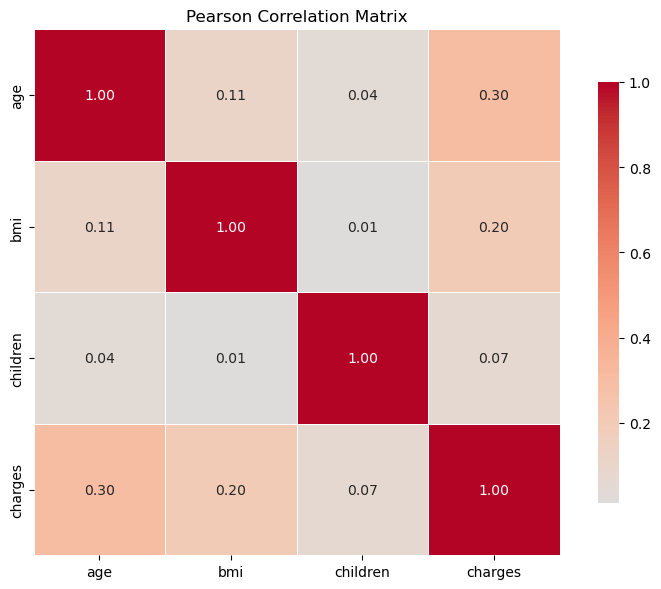

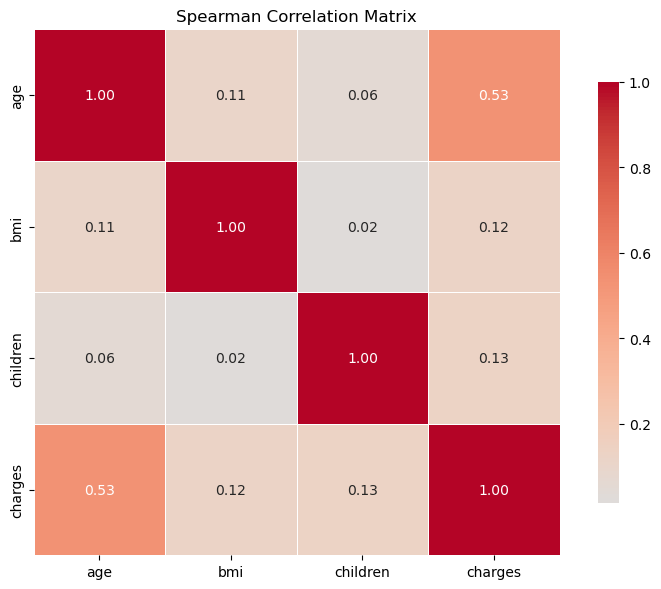

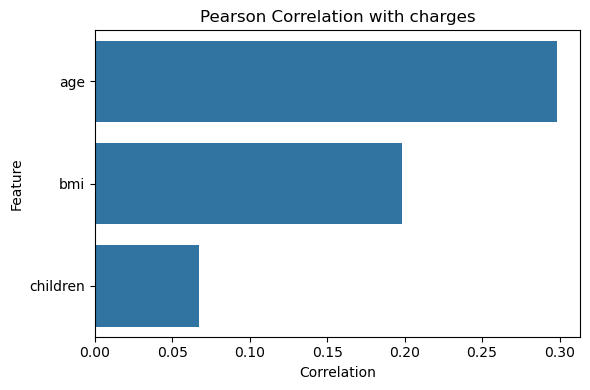

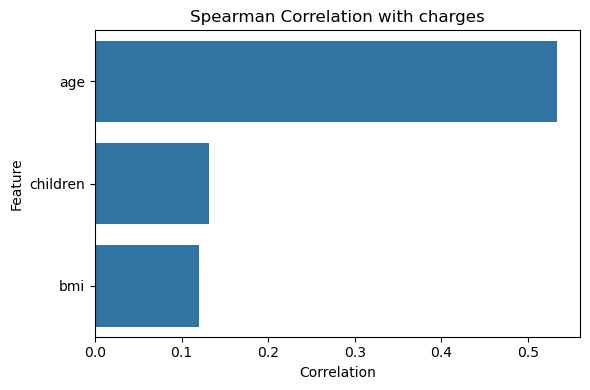

In [40]:
corr_matrix_pearson = compute_correlation_matrix(df, exclude_columns="log_charges")
plot_correlation_heatmap(corr_matrix_pearson, title="Pearson Correlation Matrix")

corr_matrix_spearman = compute_correlation_matrix(df, method="spearman", exclude_columns="log_charges")
plot_correlation_heatmap(corr_matrix_spearman, title="Spearman Correlation Matrix")

plot_target_correlations(df, target="charges", exclude_columns="log_charges")
plot_target_correlations(df, target="charges", method="spearman", exclude_columns="log_charges")

In [41]:
def pointbiserial_summary(df, target, binary_only=True, exclude_columns=None):
    """
    Compute Point-Biserial correlation between a numeric target and binary/categorical features.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe
    target : str
        Numeric target variable (e.g., 'charges')
    binary_only : bool, default True
        If True, only features with 2 unique values are considered
    exclude_columns : list of str, optional
        Columns to exclude from the correlation analysis

    Returns
    -------
    summary_df : pandas.DataFrame
        DataFrame with columns: feature, r (correlation), p_value, mean_group0, mean_group1
        Values are rounded for better readability.
    """
    summary = []

    for col in df.columns:
        if col == target:
            continue
        if exclude_columns and col in exclude_columns:
            continue

        unique_vals = df[col].dropna().unique()
        if binary_only and len(unique_vals) != 2:
            continue

        # Encode categorical as 0/1
        col_encoded = df[col].astype("category").cat.codes

        # Point-Biserial correlation
        r, p = pointbiserialr(df[target], col_encoded)

        # Group means
        means = df.groupby(col)[target].mean()
        mean0 = means.iloc[0]
        mean1 = means.iloc[1]

        # Append rounded values
        summary.append({
            "feature": col,
            "r": round(r, 2),
            "p_value": round(p, 3),
            "mean_group0": round(mean0, 1),
            "mean_group1": round(mean1, 1)
        })

    summary_df = pd.DataFrame(summary).sort_values(by="r", key=abs, ascending=False)
    return summary_df


def plot_pointbiserial(
    summary_df,
    figsize=(8,5),
    title=None,
    top_k=None,
    filter_thresholds=False,
    min_r=0.1,
    alpha=0.05
):
    """
    Plot Point-Biserial correlations with significance color coding.

    Parameters
    ----------
    summary_df : pandas.DataFrame
        Output of pointbiserial_summary(), should contain columns: 
        'feature', 'r', 'p_value', 'mean_group0', 'mean_group1'
    figsize : tuple
        Figure size
    title : str, optional
        Plot title
    top_k : int or None, optional
        If int, only show top_k features by absolute r. Default is None (show all).
    filter_thresholds : bool, optional
        If True, only show features with |r| >= min_r and p < alpha.
    min_r : float, optional
        Minimum absolute r value to display if filter_thresholds is True.
    alpha : float, optional
        Significance threshold for p-value if filter_thresholds is True.

    Color coding
    ------------
    - Green: positive correlation (r > 0) and significant (p < alpha)
    - Red: negative correlation (r < 0) and significant (p < alpha)
    - Grey: not significant (p >= alpha)
    """
    # Filter features based on thresholds if requested
    if filter_thresholds:
        summary_df = summary_df[(summary_df['r'].abs() >= min_r) & (summary_df['p_value'] < alpha)]
    
    # Optional Top-K filter
    if top_k is not None:
        summary_df = summary_df.reindex(summary_df['r'].abs().sort_values(ascending=False).index[:top_k])
    
    # Sort by absolute r for plotting order
    summary_df = summary_df.sort_values(by="r", key=abs, ascending=True).reset_index(drop=True)
    
    plt.figure(figsize=figsize)
    
    # Assign colors based on r and p-value
    colors = []
    for row in summary_df.itertuples():
        if row.p_value < alpha:
            colors.append('green' if row.r >= 0 else 'red')
        else:
            colors.append('grey')
    
    # Horizontal bar plot
    bars = plt.barh(summary_df['feature'], summary_df['r'], color=colors)
    
    plt.xlabel("Point-Biserial r")
    plt.ylabel("Feature")
    plt.title(title if title else "Point-Biserial Correlations with Target (Significance Colored)")
    
    # Annotate bars: fixed offset to the right of bar end
    total_range = summary_df['r'].max() - summary_df['r'].min()
    offset = total_range * 0.01  # 1% of total range
    
    for bar, row in zip(bars, summary_df.itertuples()):
        if row.r >= 0:
            xpos = bar.get_x() + bar.get_width() + offset  # right of positive bar
        else:
            xpos = bar.get_x() + offset  # right of negative bar's left end
        plt.text(xpos, bar.get_y() + bar.get_height()/2, f"r={row.r}, p={row.p_value}", 
                 va='center', ha='left')
    
    plt.tight_layout()
    plt.show()

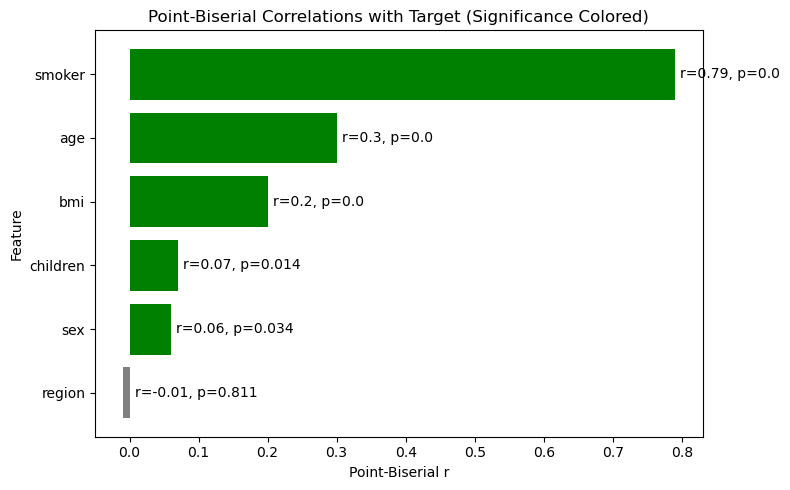

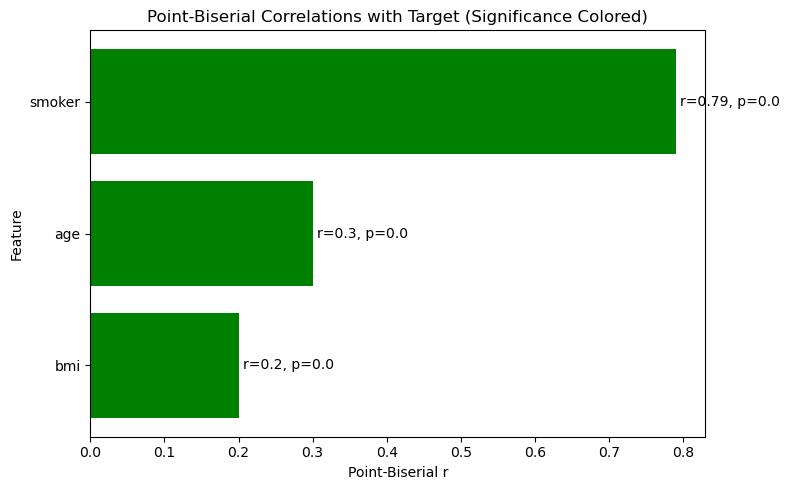

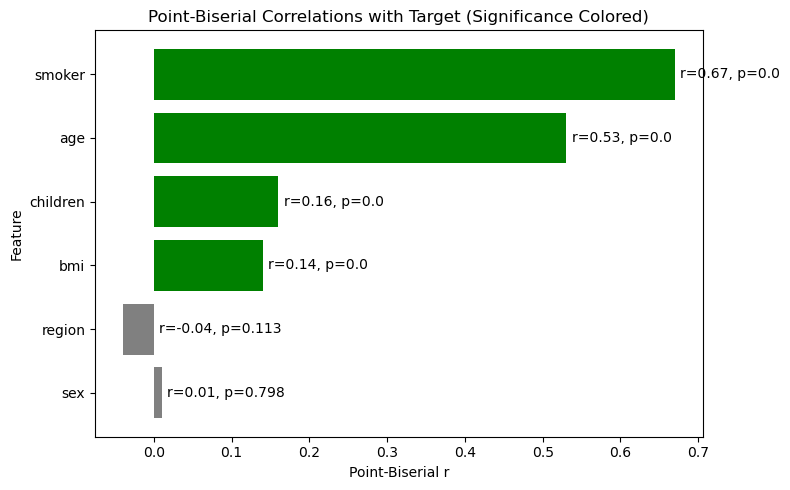

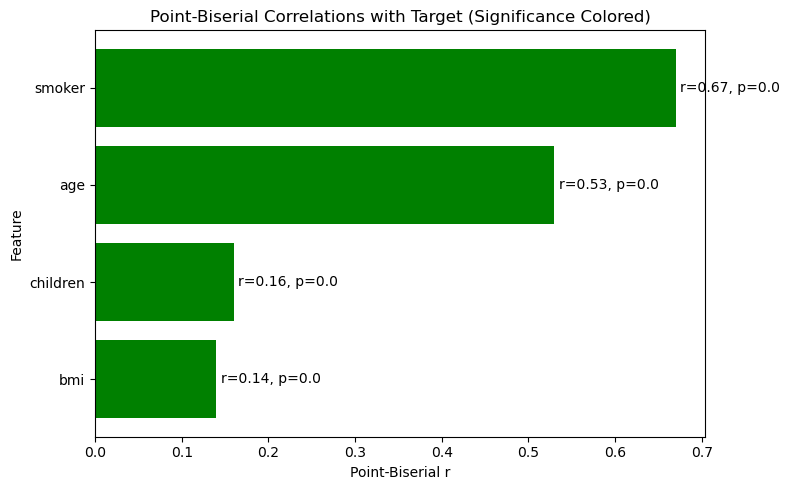

In [42]:
summary = pointbiserial_summary(df, target="charges", binary_only=False, exclude_columns="log_charges")
plot_pointbiserial(summary)
plot_pointbiserial(summary, filter_thresholds=True)

summary = pointbiserial_summary(df, target="log_charges", binary_only=False, exclude_columns="charges")
plot_pointbiserial(summary)
plot_pointbiserial(summary, filter_thresholds=True)

## 5. Group-Based Analysis

A detailed group comparison was performed for **smokers vs. non-smokers**:

- Descriptive statistics (mean, median, spread, quartiles) were computed for each group.
- Boxplots with overlaid group means were used to visually compare the distributions.
- Differences in average charges between groups were highlighted to quantify the effect size.

This analysis confirmed substantial differences in insurance charges between the two groups.

In [43]:
def compare_groups(df, target, group_col):
    """
    Compute descriptive statistics for a numeric target, grouped by a binary/categorical feature.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe
    target : str
        Numeric target variable (e.g., 'charges')
    group_col : str
        Column to group by (e.g., 'smoker')

    Returns
    -------
    summary_df : pandas.DataFrame
        Descriptive statistics per group and difference between means
    """
    # Use describe to get standard descriptive stats
    grouped = df.groupby(group_col)[target].describe()
    
    # Add difference of means if binary
    if grouped.shape[0] == 2:
        diff = grouped['mean'].iloc[1] - grouped['mean'].iloc[0]
        grouped['mean_diff'] = [diff, diff]
    
    return grouped


def plot_group_comparison(df, target, group_col, figsize=(7,5), title=None):
    """
    Plot comparison of a numeric target between groups with colored boxes.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe
    target : str
        Numeric target variable (e.g., 'charges')
    group_col : str
        Column to group by (e.g., 'smoker')
    figsize : tuple
        Figure size
    title : str, optional
        Plot title
    """
    plt.figure(figsize=figsize)
    
    # Determine unique groups in the order they appear
    unique_groups = df[group_col].unique()
    palette = sns.color_palette("Set2", n_colors=len(unique_groups))
    color_dict = {grp: col for grp, col in zip(unique_groups, palette)}
    
    # Plot each group separately to assign colors without using hue
    for i, grp in enumerate(unique_groups):
        sns.boxplot(
            x=[i]*len(df[df[group_col]==grp]),
            y=df[df[group_col]==grp][target],
            width=0.6,
            color=color_dict[grp]
        )
    
    # Compute means in the same order as unique_groups
    means = [df[df[group_col]==grp][target].mean() for grp in unique_groups]
    
    # Overlay mean points and annotate them above each box
    for i, mean_val in enumerate(means):
        plt.scatter(i, mean_val, color='black', zorder=10)
        plt.text(i, mean_val + 0.02*df[target].max(), f"{mean_val:.2f}", 
                 ha='center', va='bottom', fontsize=9)
    
    # Set x-axis labels
    plt.xticks(range(len(unique_groups)), unique_groups)
    plt.title(title if title else f"{target} by {group_col}")
    plt.ylabel(target)
    plt.xlabel(group_col)
    plt.tight_layout()
    plt.show()

         count          mean           std         min           25%  \
smoker                                                                 
no      1063.0   8440.660307   5992.973800   1121.8739   3988.883500   
yes      274.0  32050.231832  11541.547176  12829.4551  20826.244213   

                50%           75%          max     mean_diff  
smoker                                                        
no       7345.72660  11363.019100  36910.60803  23609.571525  
yes     34456.34845  41019.207275  63770.42801  23609.571525  


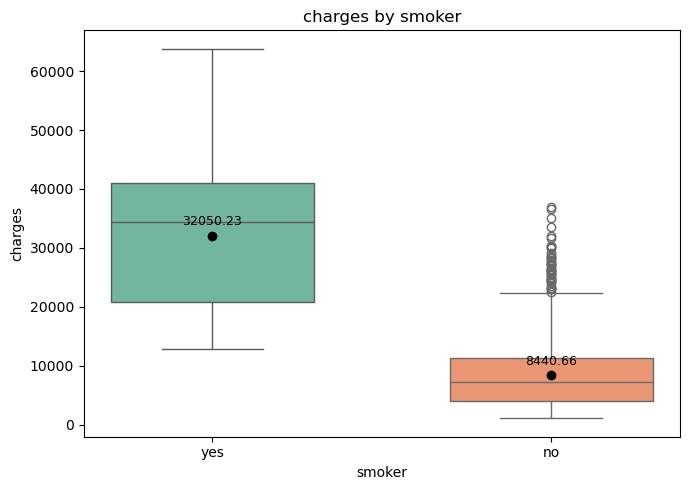

In [44]:
summary_smoker = compare_groups(df, target='charges', group_col='smoker')
print(summary_smoker)
plot_group_comparison(df, target='charges', group_col='smoker')

## Conclusion and Key Findings

The exploratory data analysis revealed several important insights into the factors influencing healthcare insurance charges.

First, the target variable `charges` exhibits a strongly right-skewed distribution, indicating the presence of a small number of individuals with very high medical costs. This motivated the additional analysis of a log-transformed target variable, which resulted in more symmetric distributions and clearer linear relationships.

Among the numerical features, **age** shows a consistent positive relationship with insurance charges, indicating that costs tend to increase with age. **BMI** also exhibits a positive association, although the relationship appears weaker and more monotonic than strictly linear. These findings were confirmed by both Pearson and Spearman correlation analyses.

The most pronounced effect is observed for the **smoker** variable. Both group-based comparisons and point-biserial correlation analysis show that smokers incur substantially higher insurance charges than non-smokers. This difference is statistically significant and represents the strongest effect among all analyzed features.

Other categorical variables, such as **sex** and **region**, show comparatively weak or negligible relationships with insurance charges. While minor differences between groups exist, their effect sizes are small and lack strong statistical significance.

Overall, the analysis demonstrates that insurance charges are primarily driven by smoking status and age, with BMI playing a secondary role. The results are consistent across multiple analytical perspectives, including visual exploration, correlation analysis, and group-based comparisons. These insights provide a solid foundation for predictive modeling and further statistical investigation.